In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the LDA_format (LDA dimensionality reduction applied) csv file as a dataframe
df = pd.read_csv('/Users/money/Downloads/CS_4641_Project_3/LDA_format.csv')

# Add a column to df that extracts the base number of each song file (to be used later to ensure that all versions of a song remain on the 
# same side of the train-test split)
df['base_num'] = df['base_name'].apply(lambda x: int(x.split('.')[-1]))
df

,filename,base_name,genre,LD1,LD2,LD3,LD4,LD5,LD6,LD7,LD8,LD9,base_num
0,jazz.00054.wav,jazz.00054,jazz,1.741767,-0.436957,0.698022,0.800926,-0.666787,0.770518,-0.381587,0.156003,1.904889,54
1,jazz.00054.wav_noise,jazz.00054,jazz,1.750552,-0.083251,0.516787,0.860747,-0.852326,1.096451,-0.730113,-0.036572,1.888814,54
2,jazz.00054.wav_stretch,jazz.00054,jazz,1.528693,-0.336435,0.908627,0.895458,-0.836701,0.587782,0.072988,0.677699,1.170446,54
3,jazz.00054.wav_shift,jazz.00054,jazz,1.719768,-0.115768,0.711301,0.975488,-0.529104,0.371364,0.133296,0.207615,1.382593,54
4,reggae.00080.wav,reggae.00080,reggae,-2.049801,2.048941,0.071842,-3.036021,0.669891,0.670445,0.186464,-0.396051,-0.315839,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,jazz.00033.wav_shift,jazz.00033,jazz,2.508146,-1.307759,3.793278,-0.889671,0.619342,0.206756,1.149783,-0.647398,-0.612094,33
3996,reggae.00099.wav,reggae.00099,reggae,-0.044524,-1.994203,-0.680506,-0.885448,0.775506,-0.546964,0.647110,-0.557299,1.945060,99
3997,reggae.00099.wav_noise,reggae.00099,reggae,-0.531329,-1.805726,-0.101888,-1.066834,0.224062,0.377162,0.648064,-0.506444,1.291302,99
3998,reggae.00099.wav_stretch,reggae.00099,reggae,0.048548,-2.318827,-0.158747,-0.635248,0.807906,-0.481107,0.821145,-0.226840,1.585270,99


Average classification report:
blues: Precision: 0.7097255560646608, Recall: 0.6925000000000001, F1-Score: 0.6978364988117196
classical: Precision: 0.9197255933117583, Recall: 0.9425000000000001, F1-Score: 0.9255976510616619
country: Precision: 0.6498455485522031, Recall: 0.6900000000000001, F1-Score: 0.6635952891306812
disco: Precision: 0.5972515577797268, Recall: 0.6825000000000001, F1-Score: 0.632154830968154
hiphop: Precision: 0.7005086360563034, Recall: 0.62, F1-Score: 0.6489993947090629
jazz: Precision: 0.8518495124946737, Recall: 0.8450000000000001, F1-Score: 0.8444016981945743
metal: Precision: 0.8153204965819235, Recall: 0.8099999999999999, F1-Score: 0.8091620553080319
pop: Precision: 0.8177014188407602, Recall: 0.79, F1-Score: 0.799677811019563
reggae: Precision: 0.6358227108261472, Recall: 0.665, F1-Score: 0.644142325446134
rock: Precision: 0.5203570032256788, Recall: 0.445, F1-Score: 0.47119942337750287

Average Model Accuracy: 0.71825


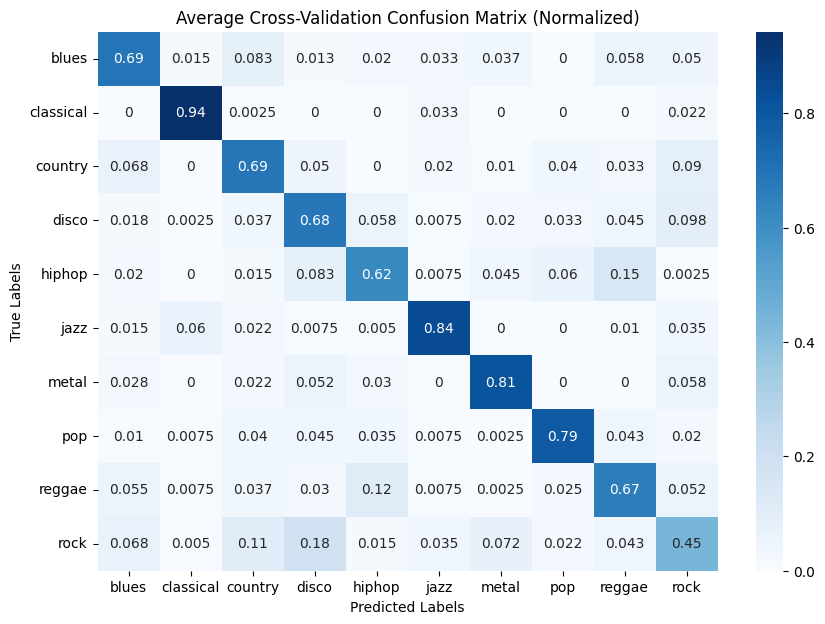

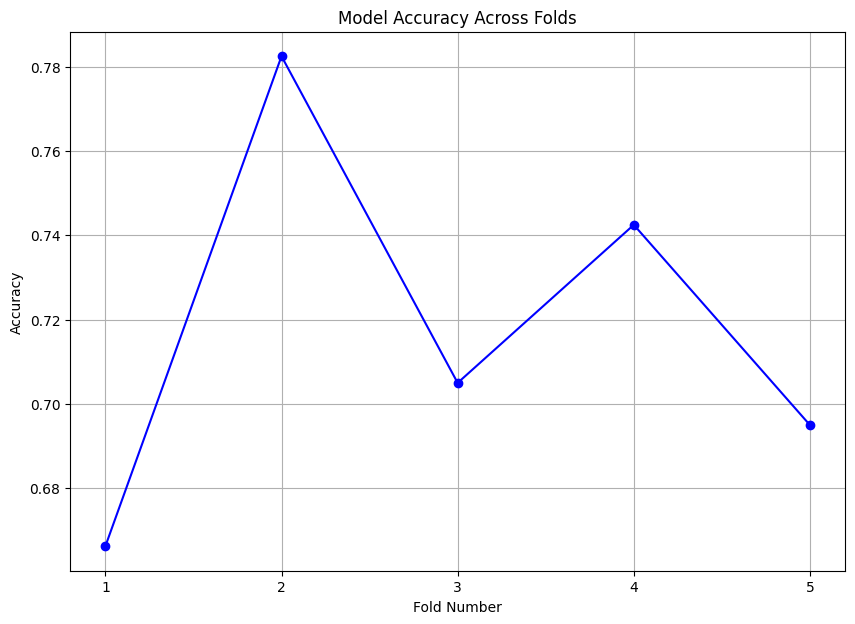

Standard Deviation of Fold Accuracies: 4.034%


In [2]:
# Perform manual 5-fold cross-validation on a SVM model with a Radial Basis Function (RBF) kernel
# Note that this manual process was done to ensure that for each fold, all 4 versions of a song remain on the same side of the train-test split.
# This was done by using the base_num as the split index, which also ensured that the testing data for each fold had the same number of songs
# from each genre (meaning that each genre had the same support, ensuring a more inclusive evaluation of the model's performance)

# Initialize the lists that will hold the performance metrics for each fold and initialize the aggregated confusion matrix 
num_folds = 5
fold_size = 99 // num_folds
results = []
accuracies = []
aggregated_cm = np.zeros((len(np.unique(df['genre'])), len(np.unique(df['genre']))))

# Loop through each fold, defining the training and testing indices based on the 'base_num' index. Then train a SVM with a RBF kernel and 
# extract the model accuracy, precision, recall, and F1-score for each genre, as well as the confusion matrix for that fold.
# Then append metrics to their respective lists
for fold in range(num_folds):
    # Define train and test indices for 'base_num'
    test_start = fold * fold_size
    test_end = test_start + fold_size
    
    # Split the dataset for the current fold
    train_df = df[~df['base_num'].between(test_start, test_end)]
    test_df = df[df['base_num'].between(test_start, test_end)]
    
    # Define the training and testing sets (splitting into features and labels)
    X_train = train_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_train = train_df['genre']
    X_test = test_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_test = test_df['genre']
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the SVM model and make a prediction of the genre
    svm_model = SVC(kernel='rbf', gamma='scale')
    svm_model.fit(X_train_scaled, y_train)
    y_pred = svm_model.predict(X_test_scaled)
    
    # Computer the accuracy for this fold and append it to the accuracy list 
    accuracies.append(accuracy_score(y_test, y_pred))
    
    # Collect the precision, recall, and F1-score for each genre for this fold and append it to the results list
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(df['genre']))
    results.append((precision, recall, fscore))
    
    # Compute the confusion matrix for this fold and add it towards the aggregated confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(df['genre']))
    aggregated_cm += cm

# Calculate the average metrics across all 5 folds
avg_precision = np.mean([result[0] for result in results], axis=0)
avg_recall = np.mean([result[1] for result in results], axis=0)
avg_fscore = np.mean([result[2] for result in results], axis=0)
avg_accuracy = np.mean(accuracies)

# Calculate the average confusion matrix across all 5 folds (normalized across each row)
avg_cm = aggregated_cm.astype('float') / aggregated_cm.sum(axis=1)[:, np.newaxis]

# Extract all 10 genres from the dataframe
labels = np.unique(df['genre'])

# Print average results of the 5-fold cross validation
print('Average classification report:')
for i, label in enumerate(labels):
    print(f'{label}: Precision: {avg_precision[i]}, Recall: {avg_recall[i]}, F1-Score: {avg_fscore[i]}')

print(f'\nAverage Model Accuracy: {avg_accuracy}')

# Plot the average normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(avg_cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Average Cross-Validation Confusion Matrix (Normalized)')
plt.show()

# Plot the fold accuracies to see variability in performance 
fold_numbers = range(1, len(accuracies) + 1)

plt.figure(figsize=(10, 7))
plt.plot(fold_numbers, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy Across Folds')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.xticks(fold_numbers)
plt.grid(True)
plt.show()

# Print standard deviation across fold accuracies 
sd = np.std(accuracies).round(5)
print(f'Standard Deviation of Fold Accuracies: {sd*100}%')


Average classification report:
blues: Precision: 0.6707120137168061, Recall: 0.6925, F1-Score: 0.680254140554022
classical: Precision: 0.9313783076740773, Recall: 0.9199999999999999, F1-Score: 0.9201975174205341
country: Precision: 0.6471717852454046, Recall: 0.6849999999999999, F1-Score: 0.6635344633647324
disco: Precision: 0.5877344304832777, Recall: 0.6375, F1-Score: 0.6078802525538658
hiphop: Precision: 0.6764697626099335, Recall: 0.62, F1-Score: 0.6373615939629281
jazz: Precision: 0.7991967042858132, Recall: 0.8324999999999999, F1-Score: 0.8096507226340366
metal: Precision: 0.8152132424537488, Recall: 0.8525, F1-Score: 0.8317235612870683
pop: Precision: 0.8176259288203216, Recall: 0.7875000000000001, F1-Score: 0.7947241560928434
reggae: Precision: 0.604278731371546, Recall: 0.6275, F1-Score: 0.6083730225942443
rock: Precision: 0.5496778485069324, Recall: 0.4175, F1-Score: 0.46836304167090503

Average Model Accuracy: 0.7072499999999999


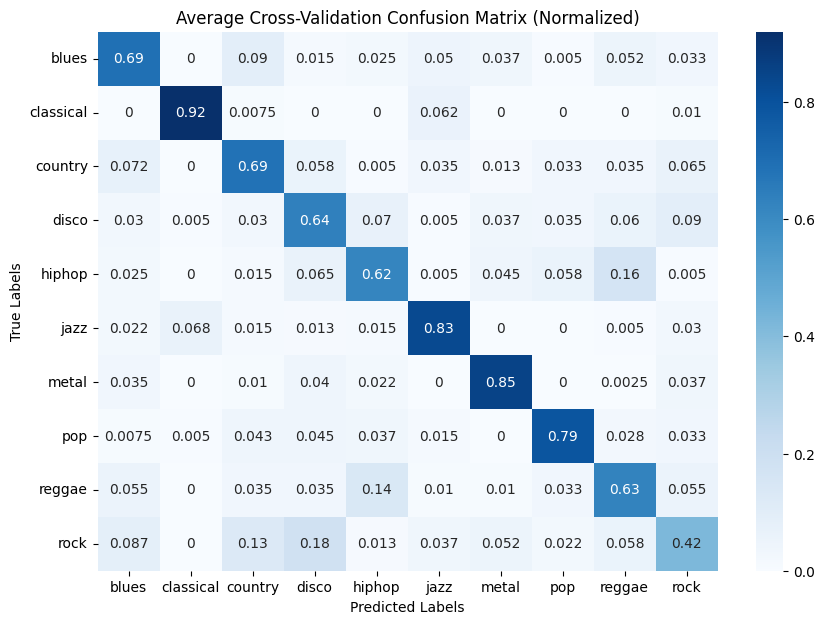

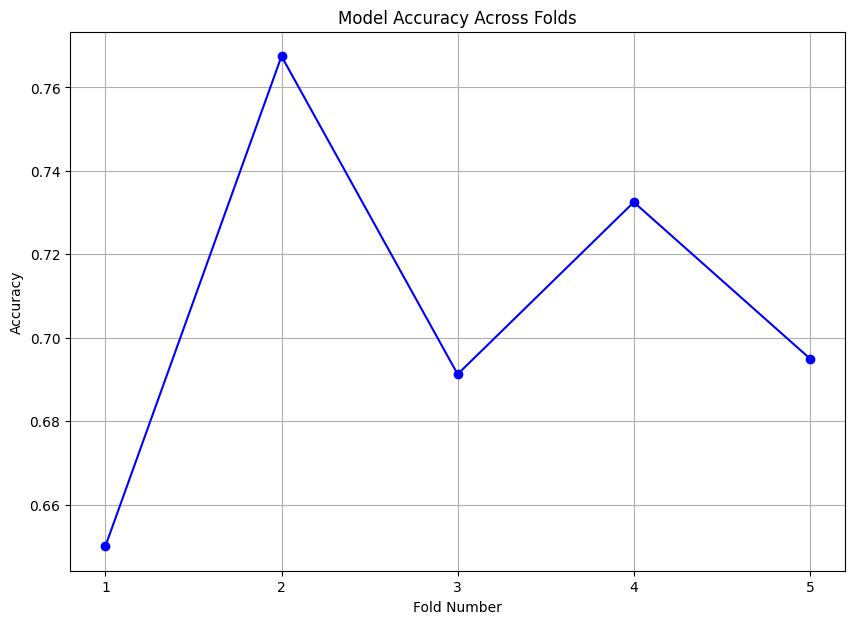

Standard Deviation of Fold Accuracies: 3.988%


In [3]:
from sklearn.ensemble import RandomForestClassifier

# Perform manual 5-fold cross-validation on a RFC model
# Note that this manual process was done to ensure that for each fold, all 4 versions of a song remain on the same side of the train-test split.
# This was done by using the base_num as the split index, which also ensured that the testing data for each fold had the same number of songs
# from each genre (meaning that each genre had the same support, ensuring a more inclusive evaluation of the model's performance)

# Initialize the lists that will hold the performance metrics and confusion matrix for each fold
num_folds = 5
fold_size = 99 // num_folds
results = []
accuracies = []
aggregated_cm = np.zeros((len(np.unique(df['genre'])), len(np.unique(df['genre']))))

# Loop through each fold, defining the training and testing indices based on the 'base_num' index. Then train a RFC model and 
# extract the model accuracy, precision, recall, and F1-score for each genre, as well as the confusion matrix for that fold.
# Then append metrics to their respective lists
for fold in range(num_folds):
    # Define train and test indices for 'base_num'
    test_start = fold * fold_size
    test_end = test_start + fold_size
    
    # Split the dataset for the current fold
    train_df = df[~df['base_num'].between(test_start, test_end)]
    test_df = df[df['base_num'].between(test_start, test_end)]
    
    # Define the training and testing sets (splitting into features and labels)
    X_train = train_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_train = train_df['genre']
    X_test = test_df.drop(['filename', 'base_name', 'genre', 'base_num'], axis=1)
    y_test = test_df['genre']
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the RFC model and make a prediction of the genre
    rfc_model = RandomForestClassifier(random_state=20)
    rfc_model.fit(X_train_scaled, y_train)
    y_pred = rfc_model.predict(X_test_scaled)
    
    # Computer the accuracy for this fold and append it to the accuracy list 
    accuracies.append(accuracy_score(y_test, y_pred))
    
    # Collect the precision, recall, and F1-score for each genre for this fold and append it to the results list
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(df['genre']))
    results.append((precision, recall, fscore))
    
    # Compute the confusion matrix for this fold and add it towards the aggregated confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(df['genre']))
    aggregated_cm += cm

# Calculate the average metrics across all 5 folds
avg_precision = np.mean([result[0] for result in results], axis=0)
avg_recall = np.mean([result[1] for result in results], axis=0)
avg_fscore = np.mean([result[2] for result in results], axis=0)
avg_accuracy = np.mean(accuracies)

# Calculate the average confusion matrix across all 5 folds (normalized across each row)
avg_cm = aggregated_cm.astype('float') / aggregated_cm.sum(axis=1)[:, np.newaxis]

# Extract all 10 genres from the dataframe
labels = np.unique(df['genre'])

# Print average results of the 5-fold cross validation
print('Average classification report:')
for i, label in enumerate(labels):
    print(f'{label}: Precision: {avg_precision[i]}, Recall: {avg_recall[i]}, F1-Score: {avg_fscore[i]}')

print(f'\nAverage Model Accuracy: {avg_accuracy}')

# Plot the average normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(avg_cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Average Cross-Validation Confusion Matrix (Normalized)')
plt.show()

# Plot the fold accuracies to see variability in performance 
fold_numbers = range(1, len(accuracies) + 1)

plt.figure(figsize=(10, 7))
plt.plot(fold_numbers, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy Across Folds')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.xticks(fold_numbers)
plt.grid(True)
plt.show()

# Print standard deviation across fold accuracies 
sd = np.std(accuracies).round(5)
print(f'Standard Deviation of Fold Accuracies: {sd*100}%')



{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
Epoch 1/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1111 - loss: 2.6685 - val_accuracy: 0.2013 - val_loss: 2.5636
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.1740 - loss: 2.5737 - val_accuracy: 0.3212 - val_loss: 2.4700
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.2257 - loss: 2.4871 - val_accuracy: 0.4588 - val_loss: 2.3662
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.3334 - loss: 2.3621 - val_accuracy: 0.5200 - val_loss: 2.2372
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.4011 - loss: 2.2337 - val_accuracy: 0.5500 - val_loss: 2.0874
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.4759 - loss: 2.0905 - val_accuracy: 0.5750 - val_loss: 1.9291
Epoch 7/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5073 - loss: 1.9567 - val_acc

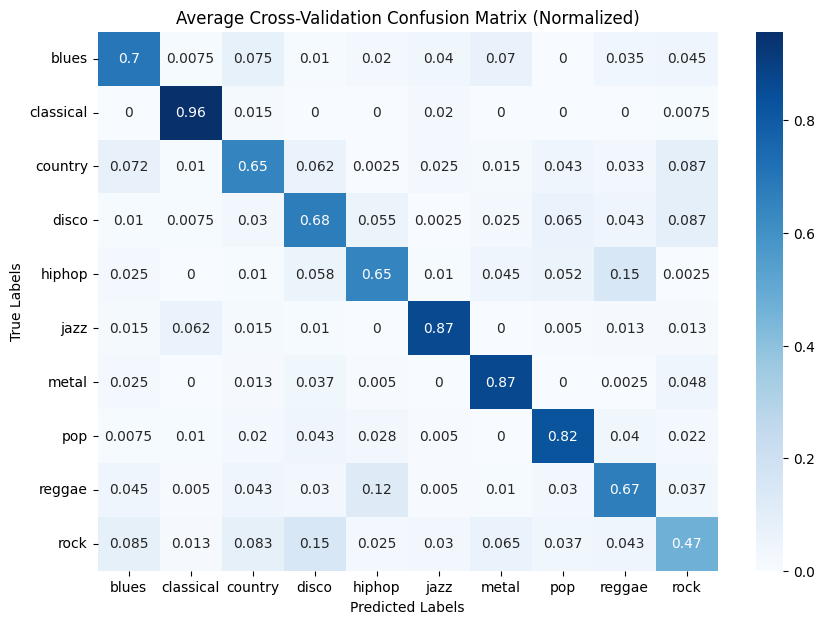

Average accuracy: 0.7332499861717224


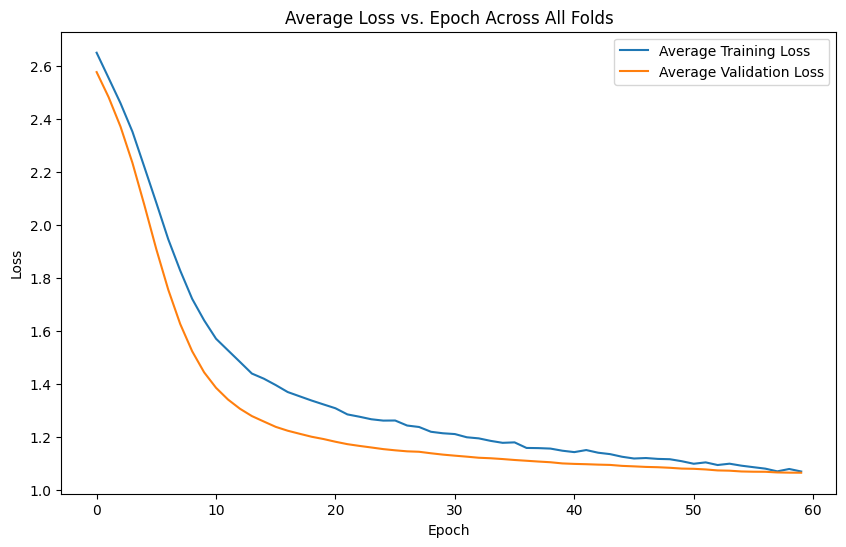

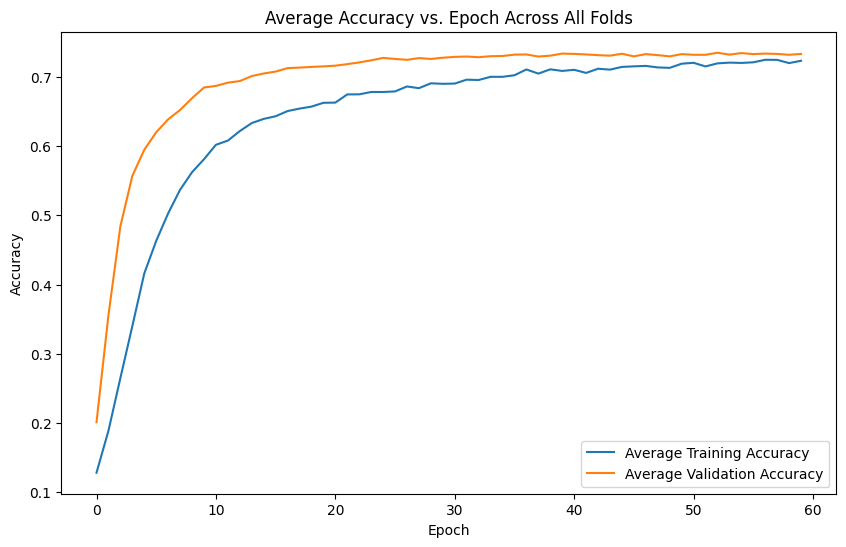

Average classification report:
blues: Precision: 0.6707120137168061, Recall: 0.6925, F1-Score: 0.680254140554022
classical: Precision: 0.9313783076740773, Recall: 0.9199999999999999, F1-Score: 0.9201975174205341
country: Precision: 0.6471717852454046, Recall: 0.6849999999999999, F1-Score: 0.6635344633647324
disco: Precision: 0.5877344304832777, Recall: 0.6375, F1-Score: 0.6078802525538658
hiphop: Precision: 0.6764697626099335, Recall: 0.62, F1-Score: 0.6373615939629281
jazz: Precision: 0.7991967042858132, Recall: 0.8324999999999999, F1-Score: 0.8096507226340366
metal: Precision: 0.8152132424537488, Recall: 0.8525, F1-Score: 0.8317235612870683
pop: Precision: 0.8176259288203216, Recall: 0.7875000000000001, F1-Score: 0.7947241560928434
reggae: Precision: 0.604278731371546, Recall: 0.6275, F1-Score: 0.6083730225942443
rock: Precision: 0.5496778485069324, Recall: 0.4175, F1-Score: 0.46836304167090503


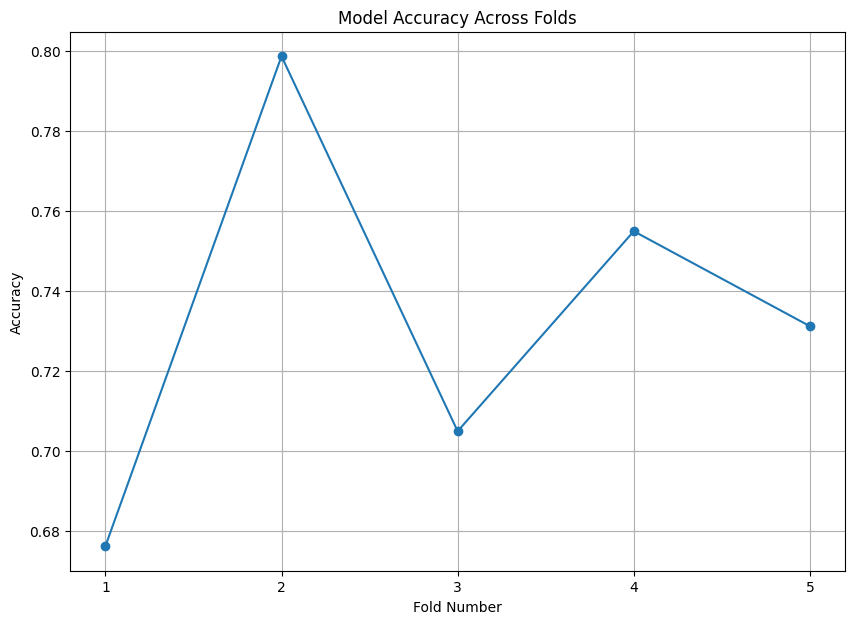

Standard Deviation of Fold Accuracies: 4.199%


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow.keras as keras


num_folds = 5
fold_size = 99 // num_folds



# Turn genres into numerical encoding for ANN
label_encoder = LabelEncoder()
df['genre_encoded'] = label_encoder.fit_transform(df['genre'])
genre_names = label_encoder.classes_
genre_to_num_mapping = {genre: label_encoder.transform([genre])[0] for genre in genre_names}
print(genre_to_num_mapping) # For reference

# Initialize lists to store metrics
results = [] # tupple of (precision, recall, fscore) for each genre
accuracies = [] # to store accuracy for each fold and later calculate average
folds_histories = [] # to store history of each fold for plotting
aggregated_cm = np.zeros((len(np.unique(df['genre'])), len(np.unique(df['genre']))))
for fold in range(num_folds):
    test_start = fold * fold_size
    test_end = test_start + fold_size

    train_df = df[~df['base_num'].between(test_start, test_end)]
    test_df = df[df['base_num'].between(test_start, test_end)]
    
    X_train = train_df.drop(columns=['filename', 'base_name', 'genre', 'base_num', 'genre_encoded'], axis=1)    
    y_train = train_df['genre_encoded']
    X_test = test_df.drop(columns=['filename', 'base_name', 'genre', 'base_num', 'genre_encoded'], axis=1)    
    y_test = test_df['genre_encoded']
    
    # print(X_train.shape)
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # print(X_train_scaled.shape)
    # print(f"Fold {fold+1}: X_train_scaled: {X_train_scaled.shape}, y_train: {y_train.shape}, X_test_scaled: {X_test_scaled.shape}, y_test: {y_test.shape}")


    # Build and compile the ANN model
    model = Sequential([
        # input layer with 57 features from each song
        Input(shape=(X_train_scaled.shape[1],)), 
        # HIDDEEN LAYERS
        keras.layers.Dense(110, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(74, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002)),
        keras.layers.Dropout(0.3),
        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # model.summary()

    # Train the network
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test),
                        epochs=60,
                        batch_size=32)
    # append the last test accuracy value from the last epoch of each fold     
    accuracies.append(history.history['val_accuracy'][-1]) 
    folds_histories.append(history.history)

    # Generate predictions
    y_pred_probabilities = model.predict(X_test_scaled)
    y_pred = np.argmax(y_pred_probabilities, axis=1)

    # Calculate percision, recall, and fscore for each genre
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(df['genre_encoded']))
    results.append((precision, recall, fscore))

    # Compute the confusion matrix for this fold and add it towards the aggregated confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(df['genre_encoded']))
    aggregated_cm += cm
    
    print(accuracies)



# Calculate the average confusion matrix across all 5 folds (normalized across each row)
avg_cm = aggregated_cm.astype('float') / aggregated_cm.sum(axis=1)[:, np.newaxis]

# Plot the average normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(avg_cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Average Cross-Validation Confusion Matrix (Normalized)')
plt.show()

# Average Loss vs. Epoch Plot
average_accuracy = np.mean(accuracies)
print(f'Average accuracy: {average_accuracy}')
avg_train_loss = np.mean([history['loss'] for history in folds_histories], axis=0)
avg_val_loss = np.mean([history['val_loss'] for history in folds_histories], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Average Loss vs. Epoch Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate average accuracy across all folds for each epoch
avg_train_accuracy = np.mean([history['accuracy'] for history in folds_histories], axis=0)
avg_val_accuracy = np.mean([history['val_accuracy'] for history in folds_histories], axis=0)

# Plot the average accuracy
plt.figure(figsize=(10, 6))
plt.plot(avg_train_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Accuracy vs. Epoch Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print average results of the 5-fold cross validation
print('Average classification report:')
for i, label in enumerate(labels):
    print(f'{label}: Precision: {avg_precision[i]}, Recall: {avg_recall[i]}, F1-Score: {avg_fscore[i]}')

# Plot accuracy by fold
plt.figure(figsize=(10, 7))
plt.plot(range(1, num_folds + 1), accuracies, marker='o', linestyle='-')
plt.title('Model Accuracy Across Folds')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_folds + 1))
plt.grid(True)
plt.show()

# Print standard deviation across fold accuracies 
sd = np.std(accuracies).round(5)
print(f'Standard Deviation of Fold Accuracies: {sd*100}%')

